In [10]:
import time
#basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#word modeling
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

import warnings

warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings('ignore',message="Precision")

In [2]:
#load data
lectures = pd.read_csv('all_lecture_text.csv')
lectures.head()

,Subject,title,d2v_text
0,Calculus,"Lec 39 | MIT 18.01 Single Variable Calculus, F...",PROFESSOR: So ||Comma|| ||Return|| Professor...
1,Probability,S01.0 Mathematical Background Overview,concepts ||Period|| I should say that ||Retur...
2,CS,8. Object Oriented Programming,FESSOR: All right everyone ||Period|| Let's g...
3,Algorithms,Recitation 9b: DNA Sequence Matching,OFESSOR: The things we ||Return|| can talk abo...
4,Algorithms,R10. Quiz 1 Review,FESSOR: All right ||Period|| So I brought a f...


In [3]:
#Split the df for training and testing
train, test = train_test_split(lectures.reset_index(drop=True), test_size=.30, random_state=43)

#The Doc2Vec model takes 'tagged_documents'
#tag the training data
tagged_tr = [TaggedDocument(words=word_tokenize(_d.lower()),\
tags=[str(i)]) for i, _d in enumerate(train.d2v_text)]

#tag testing data
tagged_test = [TaggedDocument(words=word_tokenize(_d.lower()),\
tags=[str(i)]) for i, _d in enumerate(test.d2v_text)]

In [4]:
#Instantiate the model

model = Doc2Vec(vector_size=100, # 100 should be fine based on the standards
                window=5, #change to 8
                alpha=.025, #initial learning rate
                min_alpha=0.00025, #learning rate drops linearly to this
                min_count=2, #ignores all words with total frequency lower than this.
                dm =1, #algorith 1=distributed memory
                workers=16)#cores to use

#build the vocab on the training data
model.build_vocab(tagged_tr)

In [5]:
#max training epochs
max_epochs = 100

#train n epochs and save the model
t1 = time.time()
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch+1))
    model.train(tagged_tr,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
   
   

print("done!")
t2 = time.time()    
model.save("5klects1.model")
#print("Model Saved")
print("Time: {}".format(t2-t1))

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

In [6]:
#Now that we have the embedding trained, we can use the infer vector method to convert the test sentences into vectors
#that can be used to model 

# Extract vectors from doc2vec model
X_train = np.array([model.docvecs[str(i)] for i in range(len(tagged_tr))])
y_train = train.Subject

# Extract test values
X_test = np.array([model.infer_vector(tagged_test[i][0]) for i in range(len(tagged_test))])
y_test = test.Subject

In [7]:
def heatconmat(y_true,y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9,6))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(y_test.unique()))
    plt.show()
    print(classification_report(y_true,y_pred))

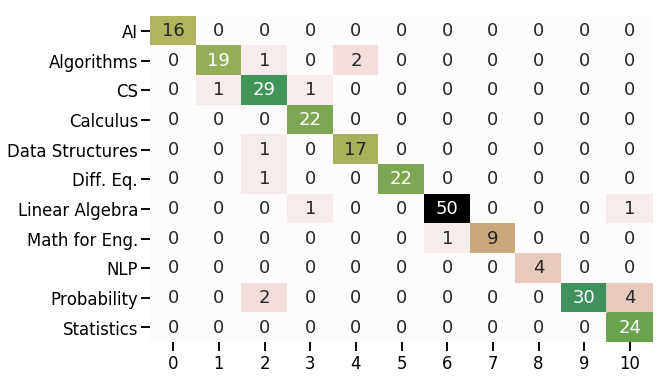

                 precision    recall  f1-score   support

             AI       1.00      1.00      1.00        16
     Algorithms       0.95      0.86      0.90        22
             CS       0.85      0.94      0.89        31
       Calculus       0.92      1.00      0.96        22
Data Structures       0.89      0.94      0.92        18
      Diff. Eq.       1.00      0.96      0.98        23
 Linear Algebra       0.98      0.96      0.97        52
  Math for Eng.       1.00      0.90      0.95        10
            NLP       1.00      1.00      1.00         4
    Probability       1.00      0.83      0.91        36
     Statistics       0.83      1.00      0.91        24

      micro avg       0.94      0.94      0.94       258
      macro avg       0.95      0.94      0.94       258
   weighted avg       0.94      0.94      0.94       258



In [14]:
lrc = LogisticRegression(C=5, multi_class='multinomial', solver='saga',max_iter=1000)
lrc.fit(X_train,y_train)
y_pred = lrc.predict(X_test)
heatconmat(y_test,y_pred)